<a href="https://colab.research.google.com/github/BjorkMagno/Portafolio/blob/main/data-science/desafios/TelecomX_Modelo/TelecomX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANÁLISIS DE EVASIÓN DE CLIENTES - TELECOM X (PARTE II: Predicción de Cancelación)

---



## Paquetería de importación.

In [1]:
import requests
import pandas as pd

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Extración de datos

In [3]:
url = 'https://raw.githubusercontent.com/BjorkMagno/Portafolio/refs/heads/main/data-science/desafios/TelecomX_Modelo/TelecomX_DataTrate.json'
response = requests.get(url)
data = response.json()

In [4]:
df = pd.DataFrame(data)
datos = pd.json_normalize(data)

datos.head()

,customerid,churn,customer_gender,customer_seniorcitizen,customer_partner,customer_dependents,customer_tenure,phone_phoneservice,phone_multiplelines,internet_internetservice,...,internet_deviceprotection,internet_techsupport,internet_streamingtv,internet_streamingmovies,account_contract,account_paperlessbilling,account_paymentmethod,account_charges_monthly,account_charges_total,account_charges_diary
0,0002-ORFBO,0,0,0,1,1,9,1,No,DSL,...,No,Yes,Yes,No,One year,1,Mailed check,65.6,593.30,2.186667
1,0003-MKNFE,0,1,0,0,0,9,1,Yes,DSL,...,No,No,No,Yes,Month to month,0,Mailed check,59.9,542.40,1.996667
2,0004-TLHLJ,1,1,0,0,0,4,1,No,Fiber optic,...,Yes,No,No,No,Month to month,1,Electronic check,73.9,280.85,2.463333
3,0011-IGKFF,1,1,1,1,0,13,1,No,Fiber optic,...,Yes,No,Yes,Yes,Month to month,1,Electronic check,98.0,1237.85,3.266667
4,0013-EXCHZ,1,0,1,1,0,3,1,No,Fiber optic,...,No,Yes,Yes,No,Month to month,1,Mailed check,83.9,267.40,2.796667


## Exploración basica de los datos.

In [5]:
datos.columns

Index(['customerid', 'churn', 'customer_gender', 'customer_seniorcitizen',
       'customer_partner', 'customer_dependents', 'customer_tenure',
       'phone_phoneservice', 'phone_multiplelines', 'internet_internetservice',
       'internet_onlinesecurity', 'internet_onlinebackup',
       'internet_deviceprotection', 'internet_techsupport',
       'internet_streamingtv', 'internet_streamingmovies', 'account_contract',
       'account_paperlessbilling', 'account_paymentmethod',
       'account_charges_monthly', 'account_charges_total',
       'account_charges_diary'],
      dtype='object')

In [6]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerid                 7043 non-null   object 
 1   churn                      7043 non-null   int64  
 2   customer_gender            7043 non-null   int64  
 3   customer_seniorcitizen     7043 non-null   int64  
 4   customer_partner           7043 non-null   int64  
 5   customer_dependents        7043 non-null   int64  
 6   customer_tenure            7043 non-null   int64  
 7   phone_phoneservice         7043 non-null   int64  
 8   phone_multiplelines        7043 non-null   object 
 9   internet_internetservice   7043 non-null   object 
 10  internet_onlinesecurity    7043 non-null   object 
 11  internet_onlinebackup      7043 non-null   object 
 12  internet_deviceprotection  7043 non-null   object 
 13  internet_techsupport       7043 non-null   objec

In [7]:
datos['churn'].value_counts()

,count
churn,
0,5174
1,1869


## Preparación de los datos.

### Eliminación y Agrupación

Eliminación de columnas irrelevantes, excluyendo variables que:

* No tienen valor predictivo (ej.: identificadores únicos).
* Son redundantes con otras.
* Pueden causar fuga de datos (data leakage).

In [8]:
# Eliminación de columna customerid
datos.drop('customerid', axis=1, inplace=True)
datos.columns

Index(['churn', 'customer_gender', 'customer_seniorcitizen',
       'customer_partner', 'customer_dependents', 'customer_tenure',
       'phone_phoneservice', 'phone_multiplelines', 'internet_internetservice',
       'internet_onlinesecurity', 'internet_onlinebackup',
       'internet_deviceprotection', 'internet_techsupport',
       'internet_streamingtv', 'internet_streamingmovies', 'account_contract',
       'account_paperlessbilling', 'account_paymentmethod',
       'account_charges_monthly', 'account_charges_total',
       'account_charges_diary'],
      dtype='object')

Realización de una copia con modificaciónes en la categoría de manera pertinente

In [9]:
# Copia de los datos.
datos_agrupados = datos.copy()

In [10]:
# Columnas de internet
columnas_internet = ['internet_onlinesecurity', 'internet_onlinebackup',
       'internet_deviceprotection', 'internet_techsupport',
       'internet_streamingtv', 'internet_streamingmovies']

In [11]:
# Columnas estaderizadas y agrupadas.
for columna in columnas_internet:
    datos_agrupados[columna] = datos_agrupados[columna].apply(lambda x: 1 if x == 'Yes' else 0)

In [12]:
datos_agrupados.head()

,churn,customer_gender,customer_seniorcitizen,customer_partner,customer_dependents,customer_tenure,phone_phoneservice,phone_multiplelines,internet_internetservice,internet_onlinesecurity,...,internet_deviceprotection,internet_techsupport,internet_streamingtv,internet_streamingmovies,account_contract,account_paperlessbilling,account_paymentmethod,account_charges_monthly,account_charges_total,account_charges_diary
0,0,0,0,1,1,9,1,No,DSL,0,...,0,1,1,0,One year,1,Mailed check,65.6,593.30,2.186667
1,0,1,0,0,0,9,1,Yes,DSL,0,...,0,0,0,1,Month to month,0,Mailed check,59.9,542.40,1.996667
2,1,1,0,0,0,4,1,No,Fiber optic,0,...,1,0,0,0,Month to month,1,Electronic check,73.9,280.85,2.463333
3,1,1,1,1,0,13,1,No,Fiber optic,0,...,1,0,1,1,Month to month,1,Electronic check,98.0,1237.85,3.266667
4,1,0,1,1,0,3,1,No,Fiber optic,0,...,0,1,1,0,Month to month,1,Mailed check,83.9,267.40,2.796667


In [13]:
# Estaderización y agrupación de los datos de la columna 'phone_multiplelines'
datos_agrupados['phone_multiplelines'] = datos_agrupados['phone_multiplelines'].apply(lambda x: 1 if x == 'Yes' else 0)

In [14]:
datos_agrupados.head()

,churn,customer_gender,customer_seniorcitizen,customer_partner,customer_dependents,customer_tenure,phone_phoneservice,phone_multiplelines,internet_internetservice,internet_onlinesecurity,...,internet_deviceprotection,internet_techsupport,internet_streamingtv,internet_streamingmovies,account_contract,account_paperlessbilling,account_paymentmethod,account_charges_monthly,account_charges_total,account_charges_diary
0,0,0,0,1,1,9,1,0,DSL,0,...,0,1,1,0,One year,1,Mailed check,65.6,593.30,2.186667
1,0,1,0,0,0,9,1,1,DSL,0,...,0,0,0,1,Month to month,0,Mailed check,59.9,542.40,1.996667
2,1,1,0,0,0,4,1,0,Fiber optic,0,...,1,0,0,0,Month to month,1,Electronic check,73.9,280.85,2.463333
3,1,1,1,1,0,13,1,0,Fiber optic,0,...,1,0,1,1,Month to month,1,Electronic check,98.0,1237.85,3.266667
4,1,0,1,1,0,3,1,0,Fiber optic,0,...,0,1,1,0,Month to month,1,Mailed check,83.9,267.40,2.796667


In [15]:
datos.columns

Index(['churn', 'customer_gender', 'customer_seniorcitizen',
       'customer_partner', 'customer_dependents', 'customer_tenure',
       'phone_phoneservice', 'phone_multiplelines', 'internet_internetservice',
       'internet_onlinesecurity', 'internet_onlinebackup',
       'internet_deviceprotection', 'internet_techsupport',
       'internet_streamingtv', 'internet_streamingmovies', 'account_contract',
       'account_paperlessbilling', 'account_paymentmethod',
       'account_charges_monthly', 'account_charges_total',
       'account_charges_diary'],
      dtype='object')

### One-hot ecoding (sin dummy trap)

In [16]:
# Variables categoricas
columnas_categorias = ['churn', 'customer_gender', 'customer_seniorcitizen',
       'customer_partner', 'customer_dependents',
       'phone_phoneservice', 'phone_multiplelines', 'internet_internetservice',
       'internet_onlinesecurity', 'internet_onlinebackup',
       'internet_deviceprotection', 'internet_techsupport',
       'internet_streamingtv', 'internet_streamingmovies', 'account_contract',
       'account_paperlessbilling', 'account_paymentmethod',
       ]

In [17]:
datos_encod = pd.get_dummies(datos_agrupados, columns=columnas_categorias, drop_first=True)
datos_encod.head()

,customer_tenure,account_charges_monthly,account_charges_total,account_charges_diary,churn_1,customer_gender_1,customer_seniorcitizen_1,customer_partner_1,customer_dependents_1,phone_phoneservice_1,...,internet_deviceprotection_1,internet_techsupport_1,internet_streamingtv_1,internet_streamingmovies_1,account_contract_One year,account_contract_Two year,account_paperlessbilling_1,account_paymentmethod_Credit card (automatic),account_paymentmethod_Electronic check,account_paymentmethod_Mailed check
0,9,65.6,593.30,2.186667,False,False,False,True,True,True,...,False,True,True,False,True,False,True,False,False,True
1,9,59.9,542.40,1.996667,False,True,False,False,False,True,...,False,False,False,True,False,False,False,False,False,True
2,4,73.9,280.85,2.463333,True,True,False,False,False,True,...,True,False,False,False,False,False,True,False,True,False
3,13,98.0,1237.85,3.266667,True,True,True,True,False,True,...,True,False,True,True,False,False,True,False,True,False
4,3,83.9,267.40,2.796667,True,False,True,True,False,True,...,False,True,True,False,False,False,True,False,False,True


In [18]:
datos_encod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   customer_tenure                                7043 non-null   int64  
 1   account_charges_monthly                        7043 non-null   float64
 2   account_charges_total                          7032 non-null   float64
 3   account_charges_diary                          7043 non-null   float64
 4   churn_1                                        7043 non-null   bool   
 5   customer_gender_1                              7043 non-null   bool   
 6   customer_seniorcitizen_1                       7043 non-null   bool   
 7   customer_partner_1                             7043 non-null   bool   
 8   customer_dependents_1                          7043 non-null   bool   
 9   phone_phoneservice_1                           7043 

#### Verificación de datos agrupados.

In [19]:
# Muestra de registro segun un dato
def registroDato (data, columna, valor):
  registro = data[data[columna] == valor]
  return registro.head()

In [20]:
registroDato(datos, 'phone_multiplelines', 'No phone service')

,churn,customer_gender,customer_seniorcitizen,customer_partner,customer_dependents,customer_tenure,phone_phoneservice,phone_multiplelines,internet_internetservice,internet_onlinesecurity,...,internet_deviceprotection,internet_techsupport,internet_streamingtv,internet_streamingmovies,account_contract,account_paperlessbilling,account_paymentmethod,account_charges_monthly,account_charges_total,account_charges_diary
10,0,1,0,0,0,54,0,No phone service,DSL,Yes,...,No,Yes,Yes,No,Two year,0,Credit card (automatic),45.20,2460.55,1.506667
14,0,0,0,0,0,56,0,No phone service,DSL,Yes,...,Yes,Yes,No,No,Two year,0,Bank transfer (automatic),45.05,2560.10,1.501667
16,0,0,0,1,1,34,0,No phone service,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,0,Mailed check,61.25,1993.20,2.041667
19,1,1,1,0,0,1,0,No phone service,DSL,No,...,No,No,No,No,Month to month,1,Electronic check,25.10,25.10,0.836667
25,1,0,0,1,1,1,0,No phone service,DSL,Yes,...,No,No,No,No,Month to month,0,Bank transfer (automatic),30.50,30.50,1.016667


In [21]:
# Verificación con el dato de la fila 10
datos_agrupados.iloc[10]['phone_multiplelines']

np.int64(0)

In [22]:
# Verificación de valores unicos en cada columna
print(f'{"*"*12}  VALORES UNICOS SEGUN LA COLUMNA   {"*"* 12} \n{"-" * 60}')
for column in columnas_internet:
    unique_values = datos[column].unique()
    print(f'Valores únicos en la columna "{column}": {len(unique_values)}')
    if len(unique_values) < 50:
      print(unique_values)
    print('-' * 60)

************  VALORES UNICOS SEGUN LA COLUMNA   ************ 
------------------------------------------------------------
Valores únicos en la columna "internet_onlinesecurity": 3
['No' 'Yes' 'No internet service']
------------------------------------------------------------
Valores únicos en la columna "internet_onlinebackup": 3
['Yes' 'No' 'No internet service']
------------------------------------------------------------
Valores únicos en la columna "internet_deviceprotection": 3
['No' 'Yes' 'No internet service']
------------------------------------------------------------
Valores únicos en la columna "internet_techsupport": 3
['Yes' 'No' 'No internet service']
------------------------------------------------------------
Valores únicos en la columna "internet_streamingtv": 3
['Yes' 'No' 'No internet service']
------------------------------------------------------------
Valores únicos en la columna "internet_streamingmovies": 3
['No' 'Yes' 'No internet service']
-------------------

In [23]:
# Verificación de valores unicos en cada columna
print(f'{"*"*12}  VALORES UNICOS SEGUN LA COLUMNA   {"*"* 12} \n{"-" * 60}')
for column in columnas_internet:
    unique_values = datos_agrupados[column].unique()
    print(f'Valores únicos en la columna "{column}": {len(unique_values)}')
    if len(unique_values) < 50:
      print(unique_values)
    print('-' * 60)

************  VALORES UNICOS SEGUN LA COLUMNA   ************ 
------------------------------------------------------------
Valores únicos en la columna "internet_onlinesecurity": 2
[0 1]
------------------------------------------------------------
Valores únicos en la columna "internet_onlinebackup": 2
[1 0]
------------------------------------------------------------
Valores únicos en la columna "internet_deviceprotection": 2
[0 1]
------------------------------------------------------------
Valores únicos en la columna "internet_techsupport": 2
[1 0]
------------------------------------------------------------
Valores únicos en la columna "internet_streamingtv": 2
[1 0]
------------------------------------------------------------
Valores únicos en la columna "internet_streamingmovies": 2
[0 1]
------------------------------------------------------------


#### Verificacion y Tratamiento de datos nulos

Identificarmos los valores nulos en las columnas y se decide entre eliminar o rellenar esas entradas.

En este proyecto, optamos por eliminar las filas con valores nulos por seguridad y simplicidad, asegurando que los datos usados estén completos.

In [24]:
print(datos_encod.isnull().sum())

customer_tenure                                   0
account_charges_monthly                           0
account_charges_total                            11
account_charges_diary                             0
churn_1                                           0
customer_gender_1                                 0
customer_seniorcitizen_1                          0
customer_partner_1                                0
customer_dependents_1                             0
phone_phoneservice_1                              0
phone_multiplelines_1                             0
internet_internetservice_Fiber optic              0
internet_internetservice_No                       0
internet_onlinesecurity_1                         0
internet_onlinebackup_1                           0
internet_deviceprotection_1                       0
internet_techsupport_1                            0
internet_streamingtv_1                            0
internet_streamingmovies_1                        0
account_cont

In [25]:
datos_encod = datos_encod.dropna(subset=['account_charges_total', 'account_charges_diary'])
datos_encod.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   customer_tenure                                7032 non-null   int64  
 1   account_charges_monthly                        7032 non-null   float64
 2   account_charges_total                          7032 non-null   float64
 3   account_charges_diary                          7032 non-null   float64
 4   churn_1                                        7032 non-null   bool   
 5   customer_gender_1                              7032 non-null   bool   
 6   customer_seniorcitizen_1                       7032 non-null   bool   
 7   customer_partner_1                             7032 non-null   bool   
 8   customer_dependents_1                          7032 non-null   bool   
 9   phone_phoneservice_1                           7032 non-n

### Normalización de datos

In [26]:
from sklearn.preprocessing import MinMaxScaler

In [32]:
# Seleccionando columnas numéricas
columnas_numericas = datos_encod.select_dtypes(include=['int64', 'float64']).columns
columnas_numericas

Index(['customer_tenure', 'account_charges_monthly', 'account_charges_total',
       'account_charges_diary'],
      dtype='object')

In [33]:
scaler = MinMaxScaler()
datos_encod[columnas_numericas] = scaler.fit_transform(datos_encod[columnas_numericas])

datos_encod.head()

,customer_tenure,account_charges_monthly,account_charges_total,account_charges_diary,churn_1,customer_gender_1,customer_seniorcitizen_1,customer_partner_1,customer_dependents_1,phone_phoneservice_1,...,internet_deviceprotection_1,internet_techsupport_1,internet_streamingtv_1,internet_streamingmovies_1,account_contract_One year,account_contract_Two year,account_paperlessbilling_1,account_paymentmethod_Credit card (automatic),account_paymentmethod_Electronic check,account_paymentmethod_Mailed check
0,0.112676,0.471144,0.066294,0.471144,False,False,False,True,True,True,...,False,True,True,False,True,False,True,False,False,True
1,0.112676,0.414428,0.060420,0.414428,False,True,False,False,False,True,...,False,False,False,True,False,False,False,False,False,True
2,0.042254,0.553731,0.030239,0.553731,True,True,False,False,False,True,...,True,False,False,False,False,False,True,False,True,False
3,0.169014,0.793532,0.140670,0.793532,True,True,True,True,False,True,...,True,False,True,True,False,False,True,False,True,False
4,0.028169,0.653234,0.028687,0.653234,True,False,True,True,False,True,...,False,True,True,False,False,False,True,False,False,True


## Correlación

In [34]:
datos_encod.columns

Index(['customer_tenure', 'account_charges_monthly', 'account_charges_total',
       'account_charges_diary', 'churn_1', 'customer_gender_1',
       'customer_seniorcitizen_1', 'customer_partner_1',
       'customer_dependents_1', 'phone_phoneservice_1',
       'phone_multiplelines_1', 'internet_internetservice_Fiber optic',
       'internet_internetservice_No', 'internet_onlinesecurity_1',
       'internet_onlinebackup_1', 'internet_deviceprotection_1',
       'internet_techsupport_1', 'internet_streamingtv_1',
       'internet_streamingmovies_1', 'account_contract_One year',
       'account_contract_Two year', 'account_paperlessbilling_1',
       'account_paymentmethod_Credit card (automatic)',
       'account_paymentmethod_Electronic check',
       'account_paymentmethod_Mailed check'],
      dtype='object')

In [29]:
correlacion = datos_encod.corr()
correlacion

,customer_tenure,account_charges_monthly,account_charges_total,account_charges_diary,churn_1,customer_gender_1,customer_seniorcitizen_1,customer_partner_1,customer_dependents_1,phone_phoneservice_1,...,internet_deviceprotection_1,internet_techsupport_1,internet_streamingtv_1,internet_streamingmovies_1,account_contract_One year,account_contract_Two year,account_paperlessbilling_1,account_paymentmethod_Credit card (automatic),account_paymentmethod_Electronic check,account_paymentmethod_Mailed check
customer_tenure,1.000000,0.246862,0.825880,0.246862,-0.354049,0.005285,0.015683,0.381912,0.163386,0.007877,...,0.361520,0.325288,0.280264,0.285402,0.202338,0.563801,0.004823,0.232800,-0.210197,-0.232181
account_charges_monthly,0.246862,1.000000,0.651065,1.000000,0.192858,-0.013779,0.219874,0.097825,-0.112343,0.248033,...,0.482607,0.338301,0.629668,0.627235,0.004810,-0.073256,0.351930,0.030055,0.271117,-0.376568
account_charges_total,0.825880,0.651065,1.000000,0.651065,-0.199484,0.000048,0.102411,0.319072,0.064653,0.113008,...,0.522881,0.432868,0.515709,0.519867,0.170569,0.358036,0.157830,0.182663,-0.060436,-0.294708
account_charges_diary,0.246862,1.000000,0.651065,1.000000,0.192858,-0.013779,0.219874,0.097825,-0.112343,0.248033,...,0.482607,0.338301,0.629668,0.627235,0.004810,-0.073256,0.351930,0.030055,0.271117,-0.376568
churn_1,-0.354049,0.192858,-0.199484,0.192858,1.000000,-0.008545,0.150541,-0.149982,-0.163128,0.011691,...,-0.066193,-0.164716,0.063254,0.060860,-0.178225,-0.301552,0.191454,-0.134687,0.301455,-0.090773
customer_gender_1,0.005285,-0.013779,0.000048,-0.013779,-0.008545,1.000000,-0.001819,-0.001379,0.010349,-0.007515,...,-0.000807,-0.008507,-0.007124,-0.010105,0.007755,-0.003603,-0.011902,0.001632,0.000844,0.013199
customer_seniorcitizen_1,0.015683,0.219874,0.102411,0.219874,0.150541,-0.001819,1.000000,0.016957,-0.210550,0.008392,...,0.059514,-0.060577,0.105445,0.119842,-0.046491,-0.116205,0.156258,-0.024359,0.171322,-0.152987
customer_partner_1,0.381912,0.097825,0.319072,0.097825,-0.149982,-0.001379,0.016957,1.000000,0.452269,0.018397,...,0.153556,0.120206,0.124483,0.118108,0.083067,0.247334,-0.013957,0.082327,-0.083207,-0.096948
customer_dependents_1,0.163386,-0.112343,0.064653,-0.112343,-0.163128,0.010349,-0.210550,0.452269,1.000000,-0.001078,...,0.013900,0.063053,-0.016499,-0.038375,0.069222,0.201699,-0.110131,0.061134,-0.149274,0.056448
phone_phoneservice_1,0.007877,0.248033,0.113008,0.248033,0.011691,-0.007515,0.008392,0.018397,-0.001078,1.000000,...,-0.070076,-0.095138,-0.021383,-0.033477,-0.003142,0.004442,0.016696,-0.006916,0.002747,-0.004463


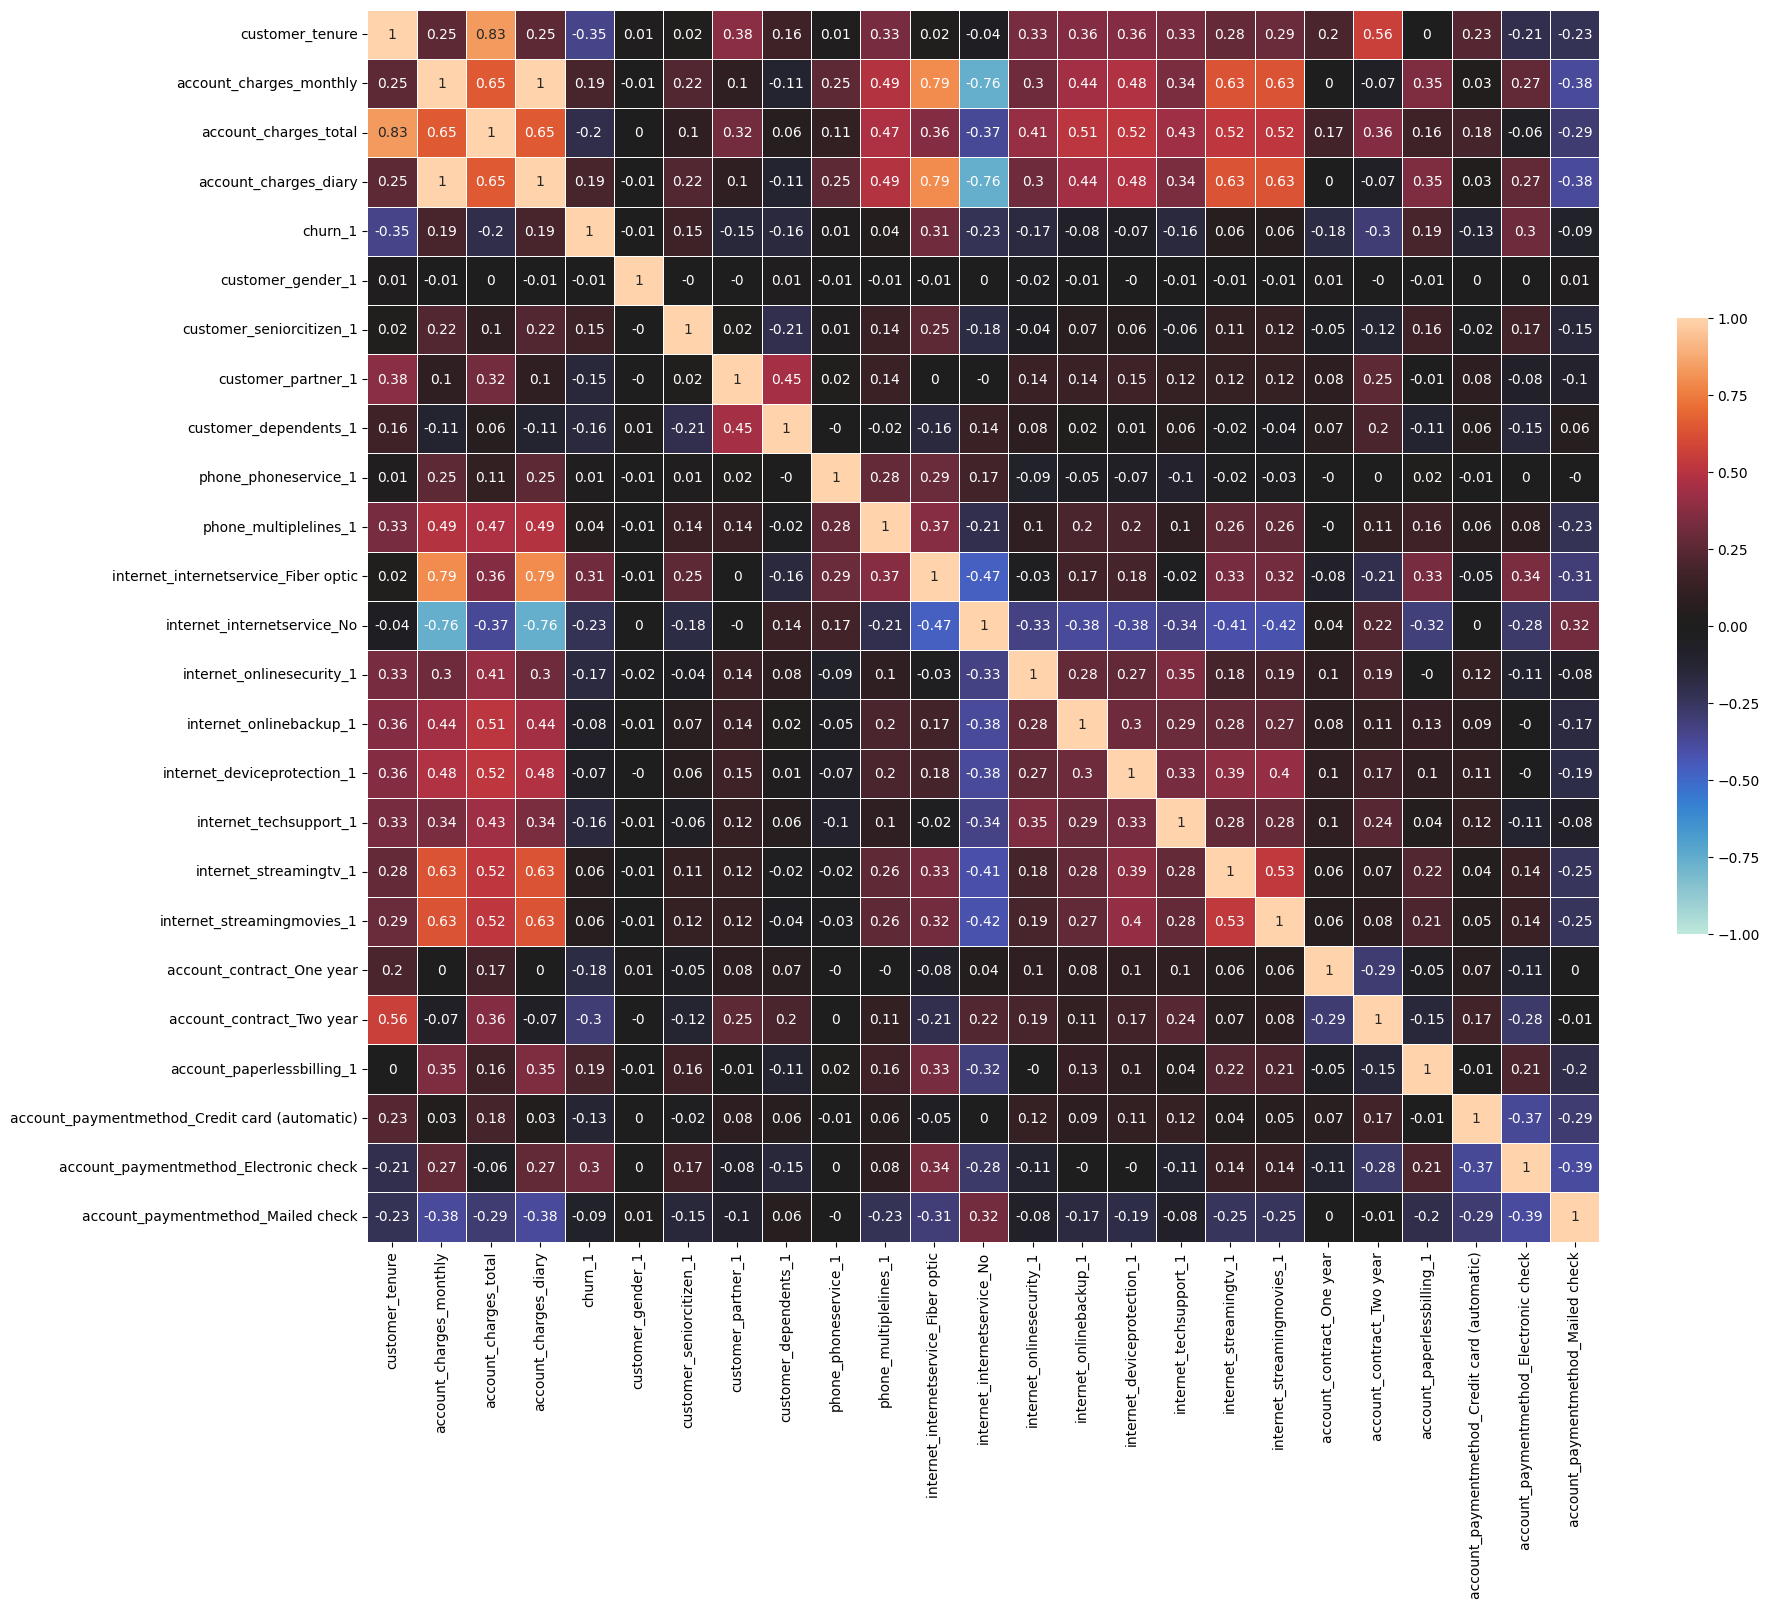

In [30]:
fig, ax = plt.subplots(figsize=(20,16))
ax = sns.heatmap(np.round(correlacion, 2), vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})
plt.show()

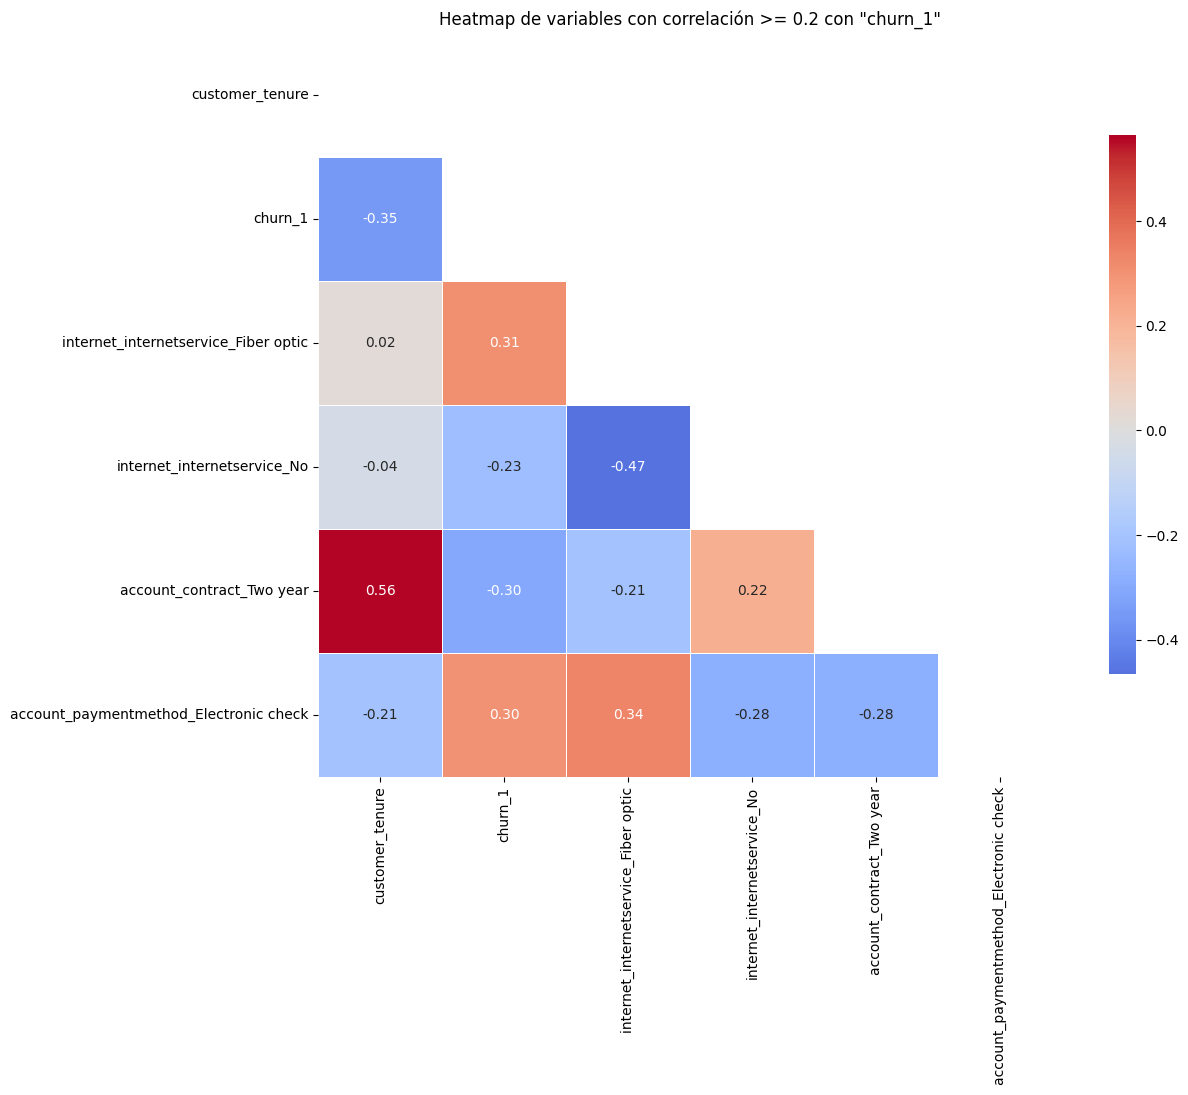

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Definir la variable objetivo
target_var = 'churn_1'

# Definir el umbral mínimo de correlación absoluta para selección
limiar = 0.2

# Filtrar variables que tengan correlación absoluta >= umbral con la variable objetivo
# Esto crea una lista con las variables relevantes
variaveis_relevantes = correlacion.index[abs(correlacion[target_var]) >= limiar].tolist()

# Asegurar que la variable objetivo esté en la lista (si no está, añadirla)
if target_var not in variaveis_relevantes:
    variaveis_relevantes.append(target_var)

# Crear una matriz de correlación solo con las variables seleccionadas
corr_filtrada = correlacion.loc[variaveis_relevantes, variaveis_relevantes]

# Generar una máscara para ocultar el triángulo superior de la matriz (incluida la diagonal)
mascara = np.triu(np.ones_like(corr_filtrada, dtype=bool))

# Graficar el heatmap con la máscara aplicada para mejor visualización
plt.figure(figsize=(12,10))
sns.heatmap(
    corr_filtrada,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.7},
    mask=mascara
)
plt.title(f'Heatmap de variables con correlación >= {limiar} con "{target_var}"')
plt.show()

## Analisis Multicolinealidad

In [39]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [40]:
# Aquí, no incluyas la variable objetivo (ej: Churn\_Yes) en el cálculo del VIF.
X = datos_encod.drop(columns=['churn_1'])

In [41]:
X_const = add_constant(X)

In [42]:
# Convert boolean columns to integers (0 or 1)
X_const = X_const.astype(float)

# Calcular el VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

# Mostrar resultado
display(vif_data.sort_values(by='VIF', ascending=False))

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
2,account_charges_monthly,inf
4,account_charges_diary,inf
11,internet_internetservice_Fiber optic,148.510456
12,internet_internetservice_No,104.222374
0,const,73.262153
9,phone_phoneservice_1,34.895471
18,internet_streamingmovies_1,24.156974
17,internet_streamingtv_1,24.081396
3,account_charges_total,10.811976
1,customer_tenure,7.584594


In [46]:
datos_encod.columns

Index(['customer_tenure', 'account_charges_monthly', 'account_charges_total',
       'account_charges_diary', 'churn_1', 'customer_gender_1',
       'customer_seniorcitizen_1', 'customer_partner_1',
       'customer_dependents_1', 'phone_phoneservice_1',
       'phone_multiplelines_1', 'internet_internetservice_Fiber optic',
       'internet_internetservice_No', 'internet_onlinesecurity_1',
       'internet_onlinebackup_1', 'internet_deviceprotection_1',
       'internet_techsupport_1', 'internet_streamingtv_1',
       'internet_streamingmovies_1', 'account_contract_One year',
       'account_contract_Two year', 'account_paperlessbilling_1',
       'account_paymentmethod_Credit card (automatic)',
       'account_paymentmethod_Electronic check',
       'account_paymentmethod_Mailed check'],
      dtype='object')

In [50]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# ====== Etapa 1: Copiar X original para não modificar o original ======
X_filtered = X_const.copy()

# ====== Etapa 2: Remover variáveis com multicolinearidade perfeita (VIF = inf) ======

# ====== Etapa 3: Remover redundâncias fortes entre variáveis numéricas ======
# Se 'Total.Day' e 'Charges.Total' são derivados de 'Monthly' e 'tenure', mantemos só um
X_filtered.drop(columns=['account_charges_diary'], inplace=True)

# ====== Etapa 4: Remover redundância entre dummies da mesma variável categórica ======
# Se usou get_dummies sem drop_first, você tem dummies redundantes para InternetService
X_filtered.drop(columns=["internet_internetservice_No"], inplace=True)

# ====== Etapa 5: Garantir que os dados estão em float para o VIF funcionar ======
X_filtered = X_filtered.astype(float)

# ====== Etapa 6: Recalcular o VIF ======
vif_data = pd.DataFrame()
vif_data["feature"] = X_filtered.columns
vif_data["VIF"] = [variance_inflation_factor(X_filtered.values, i) for i in range(X_filtered.shape[1])]

# ====== Etapa 7: Exibir os resultados ======
display(vif_data.sort_values(by="VIF", ascending=False))

,feature,VIF
0,const,26.956799
2,account_charges_monthly,22.872213
3,account_charges_total,10.803153
10,internet_internetservice_Fiber optic,7.658029
1,customer_tenure,7.583667
18,account_contract_Two year,2.648624
16,internet_streamingmovies_1,2.458872
15,internet_streamingtv_1,2.437465
21,account_paymentmethod_Electronic check,1.975617
14,internet_techsupport_1,1.884392


### VIF2

In [52]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# === Eliminar la variable account.Charges.Total ===
X_final = X_filtered.drop(columns=["account_charges_total"])

# === Recalcular el VIF ===
vif_data_final = pd.DataFrame()
vif_data_final["feature"] = X_final.columns
vif_data_final["VIF"] = [variance_inflation_factor(X_final.values, i) for i in range(X_final.shape[1])]

# === Mostrar los resultados ordenados ===
display(vif_data_final.sort_values(by="VIF", ascending=False))

,feature,VIF
2,account_charges_monthly,22.336364
0,const,21.862879
9,internet_internetservice_Fiber optic,7.553029
1,customer_tenure,2.826562
17,account_contract_Two year,2.630079
15,internet_streamingmovies_1,2.417444
14,internet_streamingtv_1,2.399620
20,account_paymentmethod_Electronic check,1.973257
13,internet_techsupport_1,1.848965
21,account_paymentmethod_Mailed check,1.837626


## Modelo Predictivos

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

In [54]:
X = datos_encod.drop(columns=['churn_1'])
y = datos_encod['churn_1']

In [55]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [56]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [57]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)

### Regresión logistica



In [58]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train_bal, y_train_bal)

# Predicciones
y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

# Evaluación
print("Regresión Logística")
print("Exactitud:", accuracy_score(y_test, y_pred_lr))
print("ROC AUC:", roc_auc_score(y_test, y_prob_lr))
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Regresión Logística
Exactitud: 0.7502369668246446
ROC AUC: 0.8455722684636976
Matriz de Confusión:
 [[1129  420]
 [ 107  454]]
              precision    recall  f1-score   support

       False       0.91      0.73      0.81      1549
        True       0.52      0.81      0.63       561

    accuracy                           0.75      2110
   macro avg       0.72      0.77      0.72      2110
weighted avg       0.81      0.75      0.76      2110



### Random Forest

In [59]:
# Instanciar y entrenar
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_bal, y_train_bal)

# Predicciones
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]

# Evaluación
print("Random Forest")
print("Exactitud:", accuracy_score(y_test, y_pred_rf))
print("ROC AUC:", roc_auc_score(y_test, y_prob_rf))
print("Matriz de Confusión:\n", confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest
Exactitud: 0.7767772511848341
ROC AUC: 0.8212077483144207
Matriz de Confusión:
 [[1305  244]
 [ 227  334]]
              precision    recall  f1-score   support

       False       0.85      0.84      0.85      1549
        True       0.58      0.60      0.59       561

    accuracy                           0.78      2110
   macro avg       0.71      0.72      0.72      2110
weighted avg       0.78      0.78      0.78      2110

